In [172]:
#Read library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout
from keras.models import Model

In [2]:
#Initial parametor
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [113]:
#For tensorboard
import requests

url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'

r = requests.get(url)

with open('helper_functions.py', 'wb') as f:
    f.write(r.content)

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

<h3>1. Preprare dataset</h3>

1. Chech the balance of dataset by each category.

2. Spirit dataset to 8:2 for train and test.

3. Read dataset and separate 8:2 for train and val

In [4]:
train_destination_folder = 'train_images'
test_destination_folder = 'test_images'

In [5]:
image_dir = Path(train_destination_folder)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.ppm'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

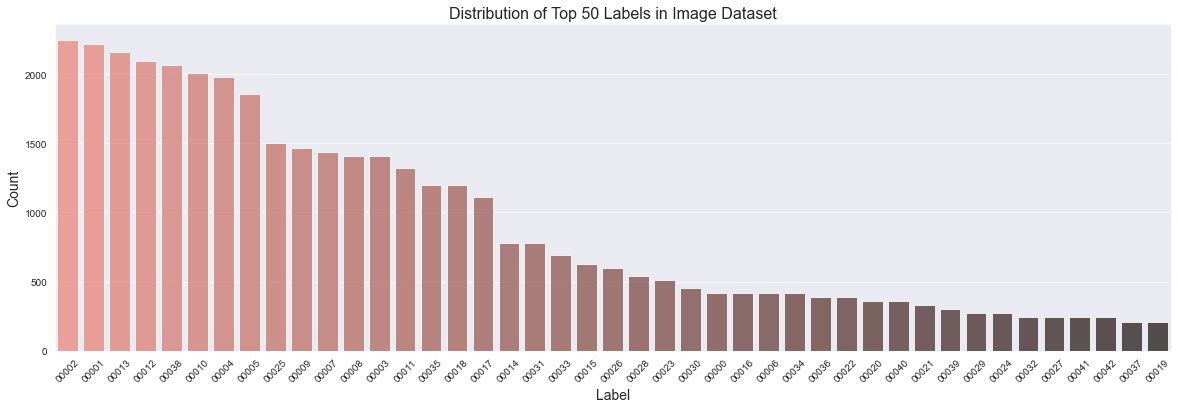

In [6]:
label_counts = image_df['Label'].value_counts()[:50]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 50 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

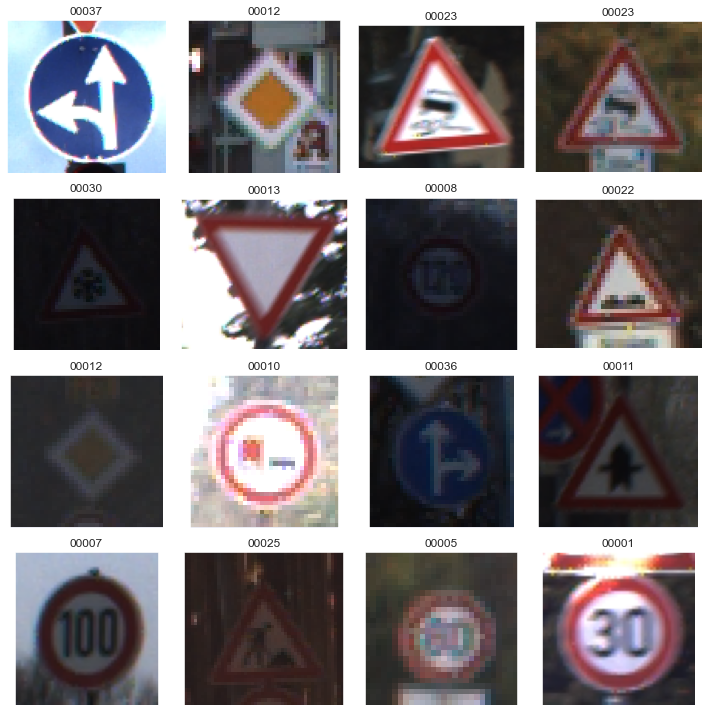

In [7]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:
#Extract 0000 category
a  = filepaths[0:29]

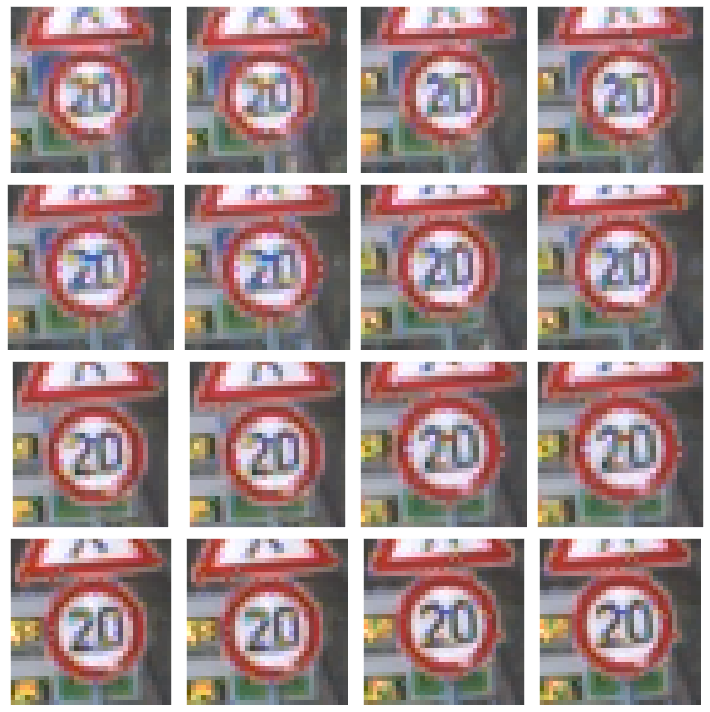

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(a[i]))
    #ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [10]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    #class_mode='binary',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    #class_mode='binary',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    #class_mode='binary',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 25228 validated image filenames belonging to 43 classes.
Found 6307 validated image filenames belonging to 43 classes.
Found 7884 validated image filenames belonging to 43 classes.


<h3>2. Preprare models</h3>

1. Data augmentation.

2. Preprare model(VGG and Efficientnet).

3. Train model

4. Check the model

In [13]:
class RandomBrightnessLayer(layers.Layer):
    def __init__(self, factor=0.2, **kwargs):
        super(RandomBrightnessLayer, self).__init__(**kwargs)
        self.factor = factor

    def call(self, images, training=None):
        if training:
            return tf.image.random_brightness(images, self.factor)
        return images

class RandomTiltLayer(layers.Layer):
    def __init__(self, max_tilt, **kwargs):
        super(RandomTiltLayer, self).__init__(**kwargs)
        self.max_tilt = max_tilt
    def build(self, input_shape):
        pass
    def call(self, inputs):
        # ティルトパラメータをランダムに生成
        random_tilt = tf.random.uniform(shape=[], minval=-self.max_tilt, maxval=self.max_tilt)
        # アフィン変換マトリックスを作成（ここでは簡単のため2Dティルトを考えます）
        transform_matrix = [1.0, random_tilt, 0.0,
                            0.0, 1.0, 0.0]
        # アフィン変換を適用
        output = tf.raw_ops.AffineTransform(images=inputs, transforms=transform_matrix)
        return output
    
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224, 224),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.3),
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
    RandomBrightnessLayer(0.4),
    #RandomTiltLayer(max_tilt=0.2)
])


<h3>VGG16

In [14]:
vgg16_model = VGG16(
    include_top=False,
    weights=None,
    input_shape=(224,224,3)
)

vgg16_model.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')



In [15]:
# Create checkpoint callback
checkpoint_path = "label_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [16]:
#Define trainable block
for layer in vgg16_model.layers[:15]:
    layer.trainable = False
#for layer in vgg16_model.layers:
  #layer.trainable = False
inputs = vgg16_model.input
x = augment(inputs)
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(43, activation="softmax")(x)


model = Model(inputs=vgg16_model.input, outputs=predictions)
#csvlogger_cb = CSVLogger('./history.csv')

optimizer = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
for i in model.layers:
    print(i.name,i.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_average_pooling2d True
dense True
dropout True
dense_1 True


In [19]:
# カテゴリーのフォルダが存在するディレクトリ
root_dir =train_destination_folder

# 各カテゴリのファイル数を取得
category_counts = {}
total_count = 0

for category in os.listdir(root_dir):
    category_path = os.path.join(root_dir, category)
    
    if os.path.isdir(category_path):
        file_count = len(os.listdir(category_path))
        category_counts[category] = file_count
        total_count += file_count

# クラスの重みを計算
class_weights = {}
for i, (category, count) in enumerate(category_counts.items()):
    class_weights[i] = total_count / float(count)

print("Unnormalized class weights:", class_weights)

# クラスの重みを正規化
sum_weights = sum(class_weights.values())
normalized_class_weights = {key: value / sum_weights for key, value in class_weights.items()}

print("Normalized class weights:", normalized_class_weights)


Unnormalized class weights: {0: 93.51421800947867, 1: 17.768122467357045, 2: 17.53131941359396, 3: 27.968107725017717, 4: 19.920747097425544, 5: 21.205265986029016, 6: 93.73634204275534, 7: 27.38584316446912, 8: 27.968107725017717, 9: 26.827328348062544, 10: 19.62357036300348, 11: 29.873580620741862, 12: 18.78296049500238, 13: 18.261453031004166, 14: 50.528809218950066, 15: 62.54041204437401, 16: 93.73634204275534, 17: 35.520252025202524, 18: 32.85845129059118, 19: 187.02843601895734, 20: 109.3157894736842, 21: 119.22356495468279, 22: 100.92838874680307, 23: 77.22700587084148, 24: 145.61992619926198, 25: 26.29113924050633, 26: 65.66222961730449, 27: 163.746887966805, 28: 72.9445471349353, 29: 145.61992619926198, 30: 87.50110864745011, 31: 50.528809218950066, 32: 163.746887966805, 33: 57.19275362318841, 34: 93.73634204275534, 35: 32.85845129059118, 36: 100.92838874680307, 37: 187.02843601895734, 38: 19.05504587155963, 39: 131.1063122923588, 40: 109.3157894736842, 41: 163.746887966805, 4

In [20]:
history = model.fit(
    train_images,
    class_weight = normalized_class_weights,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "label_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/label_classification/20230916-075021
Epoch 1/50
789/789 [==============================] - 4266s 5s/step - loss: 0.0311 - accuracy: 0.4074 - val_loss: 0.8211 - val_accuracy: 0.7701 - lr: 1.0000e-04
Epoch 2/50
789/789 [==============================] - 4231s 5s/step - loss: 0.0052 - accuracy: 0.9000 - val_loss: 0.1187 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 3/50
789/789 [==============================] - 4258s 5s/step - loss: 0.0014 - accuracy: 0.9663 - val_loss: 0.0799 - val_accuracy: 0.9786 - lr: 1.0000e-04
Epoch 4/50
789/789 [==============================] - 4285s 5s/step - loss: 4.7030e-04 - accuracy: 0.9857 - val_loss: 0.0354 - val_accuracy: 0.9906 - lr: 1.0000e-04
Epoch 5/50
789/789 [==============================] - 4274s 5s/step - loss: 8.5833e-04 - accuracy: 0.9801 - val_loss: 0.0723 - val_accuracy: 0.9810 - lr: 1.0000e-04
Epoch 6/50
789/789 [==============================] - 4284s 5s/step - loss: 0.0013 - accuracy: 0.9809 -

In [21]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.01567
Test Accuracy: 99.57%


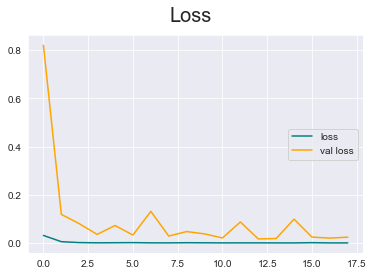

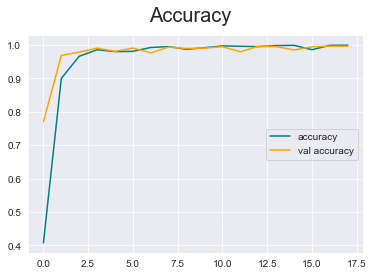

In [22]:
# Plotting the loss
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="right")
plt.show()

# Plotting the accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="right")
plt.show()


<h3>Prediction for lables: For Multi category

In [23]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

247/247 [==============================] - 887s 4s/step
The first 5 predictions: ['00028', '00002', '00035', '00014', '00010']


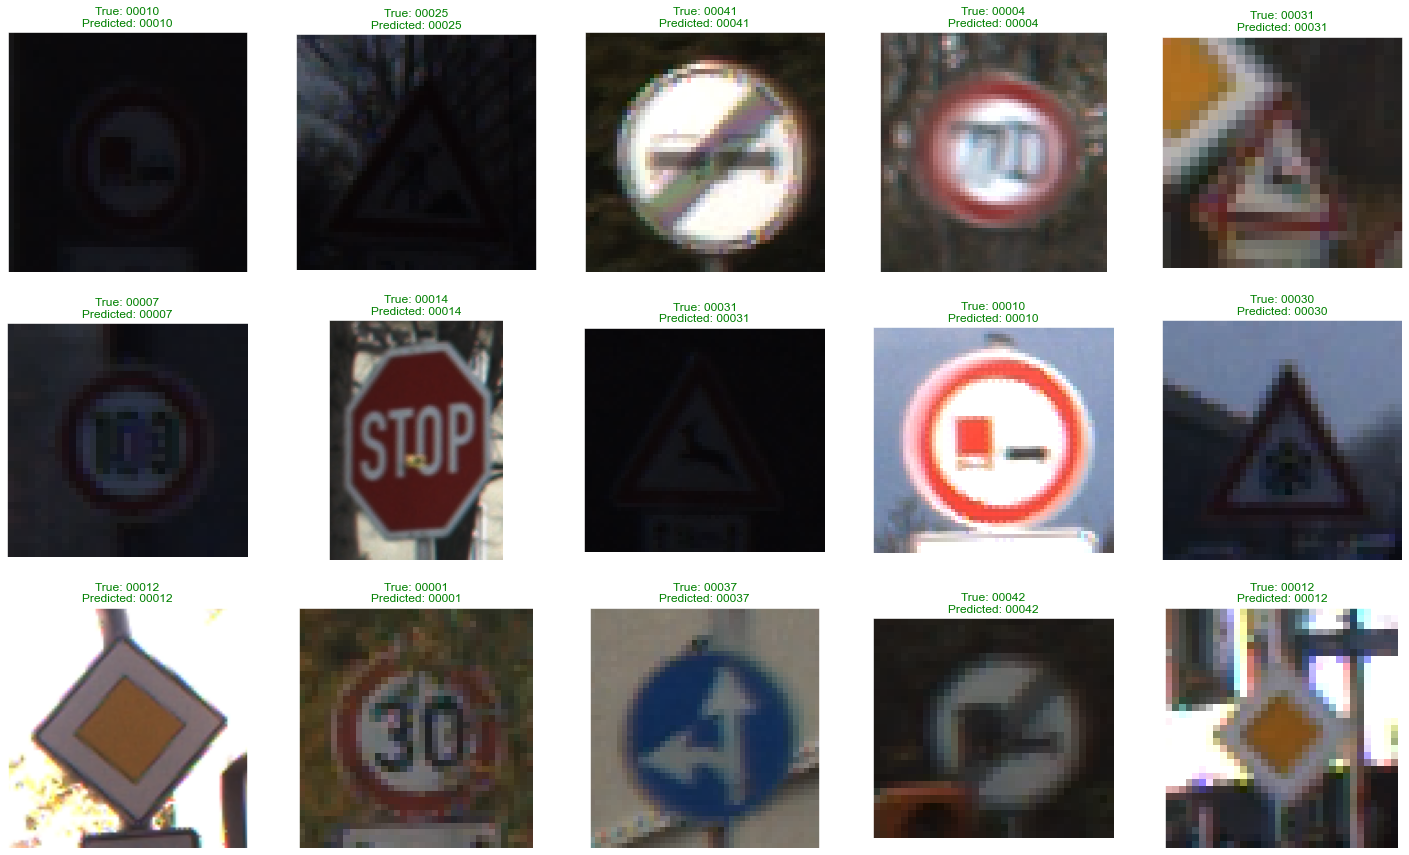

<Figure size 432x288 with 0 Axes>

In [24]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [25]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       00000       0.99      1.00      0.99        89
       00001       1.00      1.00      1.00       469
       00002       1.00      1.00      1.00       449
       00003       1.00      0.99      0.99       293
       00004       1.00      0.99      1.00       413
       00005       0.98      1.00      0.99       352
       00006       1.00      1.00      1.00        73
       00007       1.00      0.97      0.99       255
       00008       0.98      0.99      0.98       290
       00009       1.00      1.00      1.00       302
       00010       1.00      1.00      1.00       369
       00011       0.99      1.00      0.99       241
       00012       1.00      1.00      1.00       426
       00013       1.00      1.00      1.00       464
       00014       1.00      0.99      1.00       161
       00015       1.00      1.00      1.00        99
       00016       1.00      1.00      1.00        94
       00017       1.00    

In [26]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
00000,0.988889,1.000000,0.994413,89.000000
00001,0.995745,0.997868,0.996805,469.000000
00002,0.997768,0.995546,0.996656,449.000000
00003,1.000000,0.989761,0.994854,293.000000
00004,0.997567,0.992736,0.995146,413.000000
00005,0.977716,0.997159,0.987342,352.000000
00006,1.000000,1.000000,1.000000,73.000000
00007,1.000000,0.972549,0.986083,255.000000
00008,0.979522,0.989655,0.984563,290.000000
00009,0.996700,1.000000,0.998347,302.000000


In [27]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

#last_conv_layer_name = "top_conv"
last_conv_layer_name ="block5_conv3"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

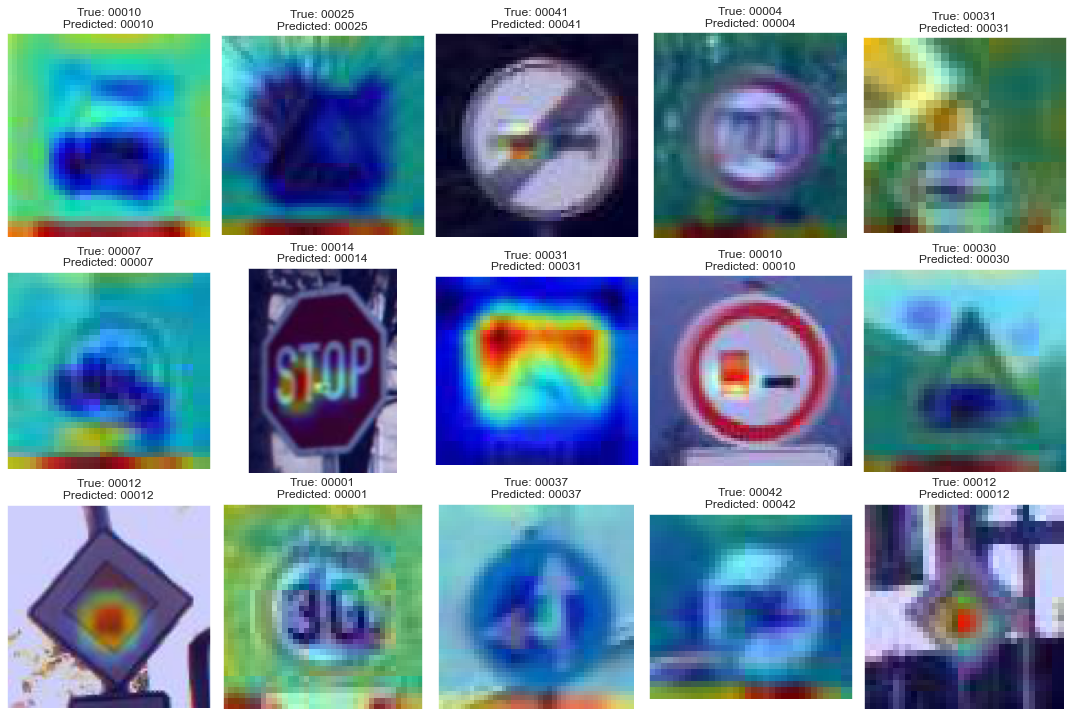

In [28]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [29]:
model.save("VGG16_2.h5")

<h3>Inference Phase</h3>

1. Prdict to dataset
2. Save csv

In [30]:
image_dir2 = Path('test_images')

# Get filepaths and labels
filepaths = list(image_dir2.glob(r'**/*.JPG')) + list(image_dir2.glob(r'**/*.jpg')) + list(image_dir2.glob(r'**/*.png'))+ list(image_dir2.glob(r'**/*.ppm'))

labels2 = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels2 = pd.Series(labels2, name='Label2')

# Concatenate filepaths and labels
image_df2 = pd.concat([filepaths, labels2], axis=1)

In [31]:
test_images2 = test_generator.flow_from_dataframe(
    dataframe=image_df2,
    x_col='Filepath',
    y_col='Label2',
    target_size=TARGET_SIZE,
    class_mode= None,
    color_mode='rgb',
    #class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 12630 validated image filenames.


In [32]:
import numpy as np
import pandas as pd

# モデルの予測を実行
predictions = model.predict(test_images2)

# クラスの確率を取得
class_probabilities = np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)

# 最も確率が高いクラスのインデックスを取得
max_prob_indices = np.argmax(class_probabilities, axis=1)

# 画像の名前を取得し、unlabelled/を削除
filenames = test_images2.filenames
cleaned_filenames = [name.replace('unlabelled/', '') for name in filenames]

# DataFrameの作成
df_dict = {
    'image_name': cleaned_filenames,
    'pred': max_prob_indices
}

# 各クラスの確率もDataFrameに追加
for i in range(class_probabilities.shape[1]):
    df_dict['class_' + str(i) + '_prob'] = class_probabilities[:, i]

df = pd.DataFrame(df_dict)

df['image_name'] = df['image_name'].str.split('/').str.get(-1)
df = df.sort_values(by='image_name')

df2 = pd.read_csv('test.csv')
df2['image_path'] = df2['image_path'].str.replace('test/', '')
df2= df2.rename(columns={'image_path': 'image_name'})
df['image_name'] = df['image_name'].str.replace(r"test_images\\", '')
df['image_name'] = df['image_name'].str.replace(r"unlebeld\\", '')
df2 = pd.merge(df2, df, on=['image_name'])
df2 = df2.iloc[0:, [0,2]]
df2.to_csv('most_probable_categories1.csv', index=False)

395/395 [==============================] - 1427s 4s/step


C:\Users\MTO3TL\AppData\Local\Temp/ipykernel_18268/1267060761.py:8: RuntimeWarning: overflow encountered in exp
  class_probabilities = np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)
C:\Users\MTO3TL\AppData\Local\Temp/ipykernel_18268/1267060761.py:8: RuntimeWarning: invalid value encountered in true_divide
  class_probabilities = np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)
C:\Users\MTO3TL\AppData\Local\Temp/ipykernel_18268/1267060761.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_name'] = df['image_name'].str.replace(r"test_images\\", '')
C:\Users\MTO3TL\AppData\Local\Temp/ipykernel_18268/1267060761.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_name'] = df['image_name'].str.replace(r"unlebeld\\", '')


In [33]:
df2 = pd.read_csv('test.csv')
df2['image_path'] = df2['image_path'].str.replace('test/', '')
df2= df2.rename(columns={'image_path': 'image_name'})
df['image_name'] = df['image_name'].str.replace(r"test_images\\", '')
df['image_name'] = df['image_name'].str.replace(r"unlebeld\\", '')
df2 = pd.merge(df2, df, on=['image_name'])
df2 = df2.iloc[0:, [0,2]]
df2.to_csv('most_probable_categories1.csv', index=False)

C:\Users\MTO3TL\AppData\Local\Temp/ipykernel_18268/1555429316.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_name'] = df['image_name'].str.replace(r"test_images\\", '')
C:\Users\MTO3TL\AppData\Local\Temp/ipykernel_18268/1555429316.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_name'] = df['image_name'].str.replace(r"unlebeld\\", '')


In [34]:
df2

,id,pred
0,0,16
1,1,1
2,2,38
3,3,33
4,4,11
...,...,...
12625,12625,12
12626,12626,33
12627,12627,5
12628,12628,7


<h3>Trial with EfficientNetB0

In [32]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights=None, # Set None to not download
    pooling='max'
)

pretrained_model.load_weights('efficientnetb0_notop.h5')

#pretrained_model.trainable = False
# 全ての層を訓練不可能に設定
for layer in pretrained_model.layers:
    layer.trainable = False

# 最後の層だけ訓練可能に設定
for layer in pretrained_model.layers[-4:]:
    layer.trainable = True
# Create checkpoint callback

checkpoint_path = "label_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


inputs1 = pretrained_model.input
y = augment(inputs1)

y = Dense(128, activation='relu')(pretrained_model.output)
y = Dropout(0.45)(y)
y = Dense(256, activation='relu')(y)
y = Dropout(0.45)(y)


outputs1 = Dense(43, activation='softmax')(y)
#outputs1 = Dense(1, activation='sigmoid')(y)

model1 = Model(inputs=inputs1, outputs=outputs1)

model1.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    #loss="binary_crossentropy",
    metrics=['accuracy']
)


In [33]:
model1.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_9 (Rescaling)        (None, 224, 224, 3)  0           ['input_9[0][0]']                
                                                                                                  
 normalization_8 (Normalization  (None, 224, 224, 3)  7          ['rescaling_9[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation) 

 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_s

 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
          

                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
          

 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization) 

                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_d

In [34]:
for i in model1.layers:
    print(i.name,i.trainable)

input_9 False
rescaling_9 False
normalization_8 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [ ]:
history1 = model1.fit(
    train_images,
    class_weight = normalized_class_weights,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=150,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "label_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/label_classification/20230905-095000
Epoch 1/150
789/789 [==============================] - 1163s 1s/step - loss: 0.0271 - accuracy: 0.3923 - val_loss: 1.1699 - val_accuracy: 0.6686 - lr: 1.0000e-04
Epoch 2/150
789/789 [==============================] - 1037s 1s/step - loss: 0.0237 - accuracy: 0.4389 - val_loss: 1.0083 - val_accuracy: 0.7225 - lr: 1.0000e-04
Epoch 3/150
789/789 [==============================] - 1010s 1s/step - loss: 0.0216 - accuracy: 0.4818 - val_loss: 0.8767 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 4/150
789/789 [==============================] - 987s 1s/step - loss: 0.0192 - accuracy: 0.5186 - val_loss: 0.7697 - val_accuracy: 0.7874 - lr: 1.0000e-04
Epoch 5/150
789/789 [==============================] - 986s 1s/step - loss: 0.0171 - accuracy: 0.5643 - val_loss: 0.6725 - val_accuracy: 0.8213 - lr: 1.0000e-04
Epoch 6/150
789/789 [==============================] - 999s 1s/step - loss: 0.0160 - accuracy: 0.5808 - val_

In [ ]:
results = model1.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
# Plotting the loss
fig = plt.figure()
plt.plot(history1.history['loss'], color='teal', label='loss')
plt.plot(history1.history['val_loss'], color='orange', label='val loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="right")
plt.show()

# Plotting the accuracy
fig = plt.figure()
plt.plot(history1.history['accuracy'], color='teal', label='accuracy')
plt.plot(history1.history['val_accuracy'], color='orange', label='val accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="right")
plt.show()


In [ ]:
# Predict the label of the test_images
pred = model1.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [ ]:
model1.save("efficientnet_1.h5")